# Importing Dependecies


In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import os
import re
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image 

In [ ]:
from keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/minor_gans/chest_xray"
METRICS_PATH="/content/drive/MyDrive/minor_gans/output/GoogleNet/"
MODEL_NAME="GoogleNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/minor_gans/chest_xray


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['NORMAL', 'PNEUMONIA']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    count=0
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        count+=1
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-NORMAL

Loaded the images of dataset-PNEUMONIA



In [ ]:

img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(5857, 1, 32, 32, 3)
(1, 5857, 32, 32, 3)
(5857, 32, 32, 3)


# Train & Test Data

In [ ]:
27558/2

13779.0

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1584] = 0
labels[1584:] = 1
names = ['NORMAL', 'PNEUMONIA']

sample 5857


In [ ]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/minor_gans/output/GoogleNet/GoogleNet.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Not using data augmentation.
Epoch 1/100
293/293 [==============================] - 15s 15ms/step - loss: 0.2222 - accuracy: 0.9125 - f1: 0.9125 - specificity: 0.9125 - sensitivity: 0.9125 - val_loss: 1.6384 - val_accuracy: 0.7321 - val_f1: 0.7323 - val_specificity: 0.7323 - val_sensitivity: 0.7323 - lr: 0.0010
Epoch 2/100
293/293 [==============================] - 3s 9ms/step - loss: 0.1513 - accuracy: 0.9443 - f1: 0.9443 - specificity: 0.9443 - sensitivity: 0.9443 - val_loss: 0.1808 - val_accuracy: 0.9232 - val_f1: 0.9240 - val_specificity: 0.9240 - val_sensitivity: 0.9240 - lr: 0.0010
Epoch 3/100
293/293 [==============================] - 4s 12ms/step - loss: 0.1367 - accuracy: 0.9509 - f1: 0.9509 - specificity: 0.9509 - sensitivity: 0.9509 - val_loss: 0.1352 - val_accuracy: 0.9522 - val_f1: 0.9527 - val_specificity: 0.9527 - val_sensitivity: 0.9527 - lr: 0.0010
Epoch 4/100
293/293 [==============================] - 3s 10ms/step - loss: 0.1224 - accuracy: 0.9545 - f1: 0.9545 - speci

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 306.5331766605377
37/37 [==============================] - 1s 13ms/step - loss: 0.2281 - accuracy: 0.9693 - f1: 0.9696 - specificity: 0.9696 - sensitivity: 0.9696
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.2221677601337433, 0.1512824147939682, 0.13674809038639069, 0.12240808457136154, 0.1147671565413475, 0.10531370341777802, 0.08996421098709106, 0.09571997821331024, 0.07247347384691238, 0.0749002993106842, 0.058233533054590225, 0.06731457263231277, 0.02968771755695343, 0.009303335100412369, 0.00422771368175745, 0.0017106134910136461, 0.0007880395860411227, 0.00040901312604546547, 0.0004352014511823654, 0.0003260369412600994, 0.00023344843066297472, 0.00019866508955601603, 0.00017132954963017255, 0.0002123095910064876, 0.00018696025654207915, 0.00015488575445488095, 0.0001493712334195152, 0.00012780145334545523, 0.000130702537

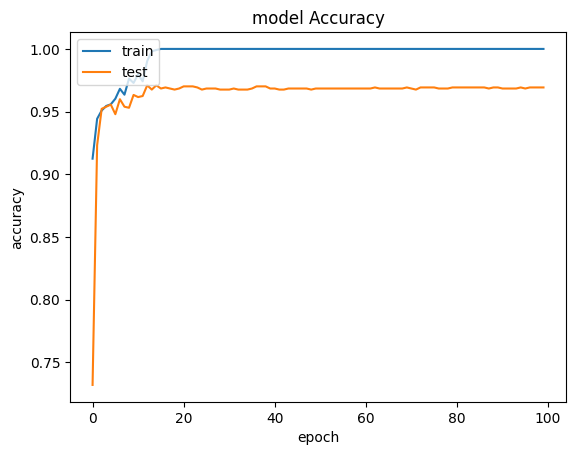

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])ww
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


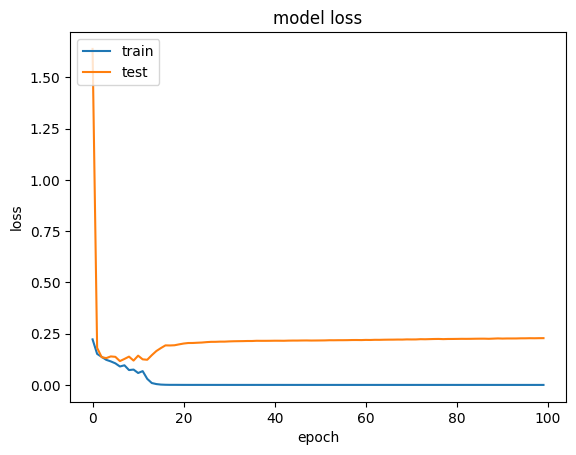

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


# with aug

In [ ]:
MODEL_NAME="GoogleNet_aug"

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 64)  0           ['conv2d_18[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['max_pooling2d_6[0][0]']        
 rmalization)                                                                               

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/minor_gans/output/GoogleNet/GoogleNet_aug.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet_aug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Using real-time data augmentation.
Epoch 1/100


<ipython-input-31-1769102c3309>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


293/293 [==============================] - 7s 18ms/step - loss: 0.3105 - accuracy: 0.8739 - f1: 0.8739 - specificity: 0.8739 - sensitivity: 0.8739 - val_loss: 0.8709 - val_accuracy: 0.7321 - val_f1: 0.7312 - val_specificity: 0.7312 - val_sensitivity: 0.7312 - lr: 0.0010
Epoch 2/100
293/293 [==============================] - 5s 16ms/step - loss: 0.2495 - accuracy: 0.9022 - f1: 0.9023 - specificity: 0.9023 - sensitivity: 0.9023 - val_loss: 0.1803 - val_accuracy: 0.9360 - val_f1: 0.9361 - val_specificity: 0.9361 - val_sensitivity: 0.9361 - lr: 0.0010
Epoch 3/100
293/293 [==============================] - 6s 19ms/step - loss: 0.2280 - accuracy: 0.9127 - f1: 0.9127 - specificity: 0.9127 - sensitivity: 0.9127 - val_loss: 0.1605 - val_accuracy: 0.9445 - val_f1: 0.9446 - val_specificity: 0.9446 - val_sensitivity: 0.9446 - lr: 0.0010
Epoch 4/100
293/293 [==============================] - 4s 15ms/step - loss: 0.2218 - accuracy: 0.9140 - f1: 0.9140 - specificity: 0.9140 - sensitivity: 0.9140 - va

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 518.8799576759338
37/37 [==============================] - 0s 5ms/step - loss: 0.1280 - accuracy: 0.9497 - f1: 0.9502 - specificity: 0.9502 - sensitivity: 0.9502
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.3105214238166809, 0.2494848519563675, 0.22795122861862183, 0.2218421995639801, 0.21175090968608856, 0.20994627475738525, 0.19775892794132233, 0.19145245850086212, 0.19440318644046783, 0.18088646233081818, 0.18745724856853485, 0.174901083111763, 0.17931176722049713, 0.1752132922410965, 0.1691095381975174, 0.1633216142654419, 0.15639956295490265, 0.16355666518211365, 0.15277081727981567, 0.1551458090543747, 0.15398696064949036, 0.1487690657377243, 0.15679582953453064, 0.15118852257728577, 0.14300334453582764, 0.12478157877922058, 0.11831115931272507, 0.11763425171375275, 0.11684643477201462, 0.1141233891248703, 0.1084441095590

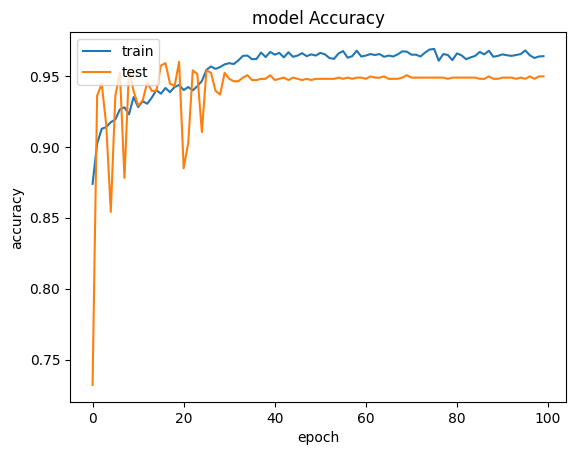

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


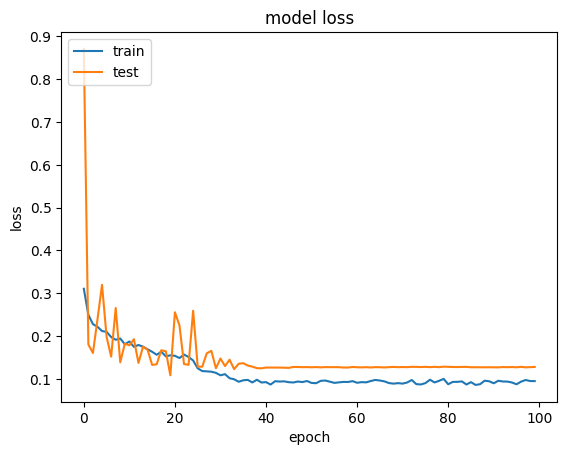

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
